In [1]:
#Importing Libraries
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from keras.preprocessing import image
from keras.models import Sequential,save_model
from keras.layers import *
from keras import Model
from keras.utils.vis_utils import plot_model
from keras.optimizers import *
from keras import regularizers
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

###  Importing CSV File

In [4]:
df_stds_7sensors=pd.read_csv('D:/MultiModal/train_raw_new.csv')
print(df_stds_7sensors.shape)
df_stds_7sensors.head()

(6400, 8)


,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135,Gas
0,555,515,377,338,666,451,416,Null
1,555,516,377,339,666,451,416,Null
2,556,517,376,337,666,451,416,Null
3,556,516,376,336,665,451,416,Null
4,556,516,376,337,665,451,416,Null


### Categorizing GAS column into 4 Classes

In [4]:
df_stds_7sensors['Gas']=df_stds_7sensors['Gas'].astype('category').cat.codes
df_stds_7sensors.head()

,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135,Gas
0,555,515,377,338,666,451,416,1
1,555,516,377,339,666,451,416,1
2,556,517,376,337,666,451,416,1
3,556,516,376,336,665,451,416,1
4,556,516,376,337,665,451,416,1


### Remove Gas Column

In [5]:
df_stds_sensors=df_stds_7sensors.iloc[:,:7]
df_stds_sensors.head()

,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135
0,555,515,377,338,666,451,416
1,555,516,377,339,666,451,416
2,556,517,376,337,666,451,416
3,556,516,376,336,665,451,416
4,556,516,376,337,665,451,416


In [6]:
seq=[]
for i,row in df_stds_sensors.iterrows():
    row1=np.array(row)
    row1=np.round(row1,decimals=3)
    seq.append(row1)
new_seq = pd.DataFrame(seq)
print(new_seq.shape)
new_seq.head()

(6400, 7)


,0,1,2,3,4,5,6
0,555,515,377,338,666,451,416
1,555,516,377,339,666,451,416
2,556,517,376,337,666,451,416
3,556,516,376,336,665,451,416
4,556,516,376,337,665,451,416


## Import Images

In [7]:
image_folder = "/content/drive/MyDrive/Thermal Cam Data/train_set"
image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        image_folder, shuffle=False, class_mode='sparse',
        target_size=(128, 128),batch_size=6400)
image_generator.class_indices

Found 6400 images belonging to 4 classes.


{'Null': 0, 'Perfume': 1, 'Smoke': 2, 'theMixture': 3}

In [8]:
images, labels = next(image_generator)

### Create Dataframe of Corresponding Sequence + Images

In [10]:
image_files = pd.Series(image_generator.filenames)
image_files = image_files.str.split("/", expand=True)[1].str[:-4]
image_files = list(image_files)
#print(image_files)
mq2=np.array(df_stds_7sensors['MQ2'])
mq3=np.array(df_stds_7sensors['MQ3'])
mq5=np.array(df_stds_7sensors['MQ5'])
mq6=np.array(df_stds_7sensors['MQ6'])
mq7=np.array(df_stds_7sensors['MQ7'])
mq8=np.array(df_stds_7sensors['MQ8'])
mq135=np.array(df_stds_7sensors['MQ135'])
Gas=np.array(df_stds_7sensors['Gas'])

df_new=pd.DataFrame({'MQ2':mq2,'MQ3':mq3,'MQ5':mq5,'MQ6':mq6,'MQ7':mq7,'MQ8':mq8,'MQ135':mq135,'Gas':Gas},index=image_files)

df_new.head()

,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135,Gas
image1000001,555,515,377,338,666,451,416,1
image1000008,555,516,377,339,666,451,416,1
image100001,556,517,376,337,666,451,416,1
image1000015,556,516,376,336,665,451,416,1
image1000022,556,516,376,337,665,451,416,1


In [11]:
df_new.head(1)

,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135,Gas
image1000001,555,515,377,338,666,451,416,1


### Check if Images are Labelled correctly

Text(0.5, 1.0, 'Ground Truth : 1.0')

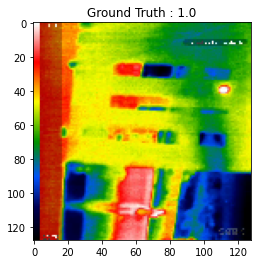

In [12]:
plt.imshow(images[3120,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(labels[3120]))

### Train - Test - Val Split + Checking Shapes of Images

In [13]:
(trainAttrX, valAttrX, trainImagesX, valImagesX) = train_test_split(df_new, images, test_size=0.20, random_state=42)
(valAttrX, testAttrX, valImagesX, testImagesX) = train_test_split(valAttrX, valImagesX, test_size=0.50, random_state=42)
print(trainAttrX.shape)
print(valAttrX.shape)
print(testAttrX.shape)
print(trainImagesX.shape)
print(valImagesX.shape)
print(testImagesX.shape)

(5120, 8)
(640, 8)
(640, 8)
(5120, 128, 128, 3)
(640, 128, 128, 3)
(640, 128, 128, 3)


In [14]:
trainY = trainAttrX["Gas"]
valY = valAttrX["Gas"]
testY = testAttrX["Gas"]
valY.head()

image500092     1
image1600279    2
image2500418    3
mix1400631      0
image2915241    3
Name: Gas, dtype: int8

In [15]:
trainAttrX=trainAttrX.drop(columns=['Gas'])
valAttrX=valAttrX.drop(columns=['Gas'])
testAttrX=testAttrX.drop(columns=['Gas'])
valAttrX.head()

,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135
image500092,772,535,431,429,571,655,485
image1600279,722,523,459,461,673,729,486
image2500418,572,354,362,395,580,575,300
mix1400631,520,399,372,343,422,255,376
image2915241,711,415,308,343,597,613,349


In [16]:
def create_array(arr):
    seq=[]
    for i,row in arr.iterrows():
        row1=np.array(row)
        row1=np.round(row1,decimals=3)
        seq.append(row1)
    seq=np.array(seq)
    return seq

### Create Data for LSTM + Reshape

In [17]:
trainAttrX_new=create_array(trainAttrX)
valAttrX_new=create_array(valAttrX)
testAttrX_new=create_array(testAttrX)
print(trainAttrX_new.shape)
print(valAttrX_new.shape)
print(testAttrX_new.shape)

(5120, 7)
(640, 7)
(640, 7)


In [18]:
trainAttrX_new=trainAttrX_new.reshape(trainAttrX_new.shape[0],7,1)
valAttrX_new=valAttrX_new.reshape(valAttrX_new.shape[0],7,1)
testAttrX_new=testAttrX_new.reshape(testAttrX_new.shape[0],7,1)
print(trainAttrX_new.shape)
print(valAttrX_new.shape)
print(testAttrX_new.shape)

(5120, 7, 1)
(640, 7, 1)
(640, 7, 1)


In [19]:
valAttrX_new[1]

array([[722],
       [523],
       [459],
       [461],
       [673],
       [729],
       [486]])

In [20]:
trainY_new=np.array(trainY)
valY_new=np.array(valY)
testY_new=np.array(testY)
print(trainY_new.shape)
print(valY_new.shape)
print(testY_new.shape)

(5120,)
(640,)
(640,)


In [21]:
def fusion_evaluation(history):
    cnn_acc = history.history['CNN_output_accuracy']
    cnn_val_acc = history.history['val_CNN_output_accuracy']
    cnn_loss = history.history['CNN_output_loss']
    cnn_val_loss = history.history['val_CNN_output_loss']
    epochs = range(len(cnn_acc))
    #fig1 = plt.figure(figsize=(10,10))
    title='CNN'
    plot_graph(cnn_acc,cnn_val_acc,cnn_loss,cnn_val_loss,epochs,title)
    
    
    lstm_acc = history.history['LSTM_output_accuracy']
    lstm_val_acc = history.history['val_LSTM_output_accuracy']
    lstm_loss = history.history['LSTM_output_loss']
    lstm_val_loss = history.history['val_LSTM_output_loss']
    title='LSTM'
    plot_graph(lstm_acc,lstm_val_acc,lstm_loss,lstm_val_loss,epochs,title)
    
    fusion_acc = history.history['FUSION_output_accuracy']
    fusion_val_acc = history.history['val_FUSION_output_accuracy']
    fusion_loss = history.history['FUSION_output_loss']
    fusion_val_loss = history.history['val_FUSION_output_loss']
    title='Fusion'
    plot_graph(fusion_acc,fusion_val_acc,fusion_loss,fusion_val_loss,epochs,title)
    
def plot_graph(acc,val_acc,loss,val_loss,epochs,title):
    fig = plt.figure(figsize=(20,6))
    fig.suptitle(title, fontsize=30)
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [22]:
def test_model(model,testI,testA,testy):
    result=model.predict([testI,testA])
    pred_cnn = np.argmax(result[0], axis=-1)
    pred_lstm = np.argmax(result[1], axis=-1)
    pred_fusion = np.argmax(result[2], axis=-1)
   
    compare=pd.DataFrame({'Actual':testY_new,'Predicted_CNN':pred_cnn,'Predicted_lstm':pred_lstm,'Predicted_fusion':pred_fusion})
    pd.set_option('display.max_rows', compare.shape[0]+1)
    print(compare)
   
    conf_matrx(testy, pred_cnn,title='CNN')
    f1_score(pred_cnn,testy)
    conf_matrx(testy, pred_lstm,title='LSTM')
    f1_score(pred_lstm,testy)
    conf_matrx(testy, pred_fusion,title='FUSION')
    f1_score(pred_fusion,testy)
   
   
def conf_matrx(testY, pred,title):
    cm = confusion_matrix(testY,pred)
    f,ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

   
def f1_score(pred, act):
    target_names = ["Class {}".format(i) for i in range(4)]
    print(classification_report(act, pred, target_names=target_names))


## Model 1 = Remove 2 Dropout layers from CNN and Use L2 in Last Layer of CNN

In [23]:
cnn_input = Input(shape = (128, 128, 3))
y = Conv2D(64, (3, 3), activation = 'relu',kernel_regularizer=regularizers.l1_l2(l1 = 0.005, l2 =0.005))(cnn_input)
y = MaxPooling2D((2, 2), padding = 'same')(y)
#y = Dropout(0.25)(y)
y= Conv2D(32, (3, 3), activation = 'relu',kernel_regularizer=regularizers.l1_l2(l1 = 0.005, l2 =0.005))(y)
y = MaxPooling2D((2, 2), padding = 'same')(y)
#y = Dropout(0.25)(y)
y= Conv2D(16, (3, 3), activation = 'relu',kernel_regularizer=regularizers.l2(0.005))(y)
y = MaxPooling2D((2, 2), padding = 'same')(y)
y = Dropout(0.25)(y)
cnn_flatten= Flatten()(y)


lstm_input = Input(shape=(7,1))
lstm_output =(LSTM(5,return_sequences=False,input_shape = (7,1),kernel_regularizer=regularizers.l2( 0.001)))(lstm_input)

merge = concatenate([cnn_flatten, lstm_output])
#output1 = Dense(16, activation='relu')(merge)
output = Dense(4, activation='softmax',name='FUSION_output')(merge)


output_cnn=Dense(4, activation='softmax',name='CNN_output')(cnn_flatten)
#model_cnn=Model(inputs=cnn1.input,outputs=output_cnn)

output_lstm=Dense(4, activation='softmax',name='LSTM_output')(lstm_output)
#model_lstm=Model(inputs=lstm1.input,outputs=output_lstm)


model_104 = Model(inputs=[cnn_input, lstm_input], outputs=[output_cnn,output_lstm,output])

model_104.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 63, 63, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 61, 61, 32)   18464       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [24]:
opt = Adam(lr=0.006, decay=1e-3)
model_104.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history_104=model_104.fit([trainImagesX, trainAttrX_new], [trainY_new,trainY_new,trainY_new],epochs=100, batch_size=20,validation_data=([valImagesX, valAttrX_new],[valY_new,valY_new,valY_new]))

Epoch 1/100
256/256 [==============================] - 137s 524ms/step - loss: 4.8793 - CNN_output_loss: 1.1244 - LSTM_output_loss: 1.4558 - FUSION_output_loss: 1.1189 - CNN_output_accuracy: 0.5209 - LSTM_output_accuracy: 0.2622 - FUSION_output_accuracy: 0.5240 - val_loss: 2.3700 - val_CNN_output_loss: 0.4004 - val_LSTM_output_loss: 1.3888 - val_FUSION_output_loss: 0.4022 - val_CNN_output_accuracy: 0.8328 - val_LSTM_output_accuracy: 0.2531 - val_FUSION_output_accuracy: 0.8359
Epoch 2/100
256/256 [==============================] - 134s 523ms/step - loss: 2.3821 - CNN_output_loss: 0.4143 - LSTM_output_loss: 1.3878 - FUSION_output_loss: 0.4135 - CNN_output_accuracy: 0.8270 - LSTM_output_accuracy: 0.2392 - FUSION_output_accuracy: 0.8306 - val_loss: 2.2673 - val_CNN_output_loss: 0.3633 - val_LSTM_output_loss: 1.3886 - val_FUSION_output_loss: 0.3661 - val_CNN_output_accuracy: 0.8422 - val_LSTM_output_accuracy: 0.2313 - val_FUSION_output_accuracy: 0.8391
Epoch 3/100
256/256 [=================

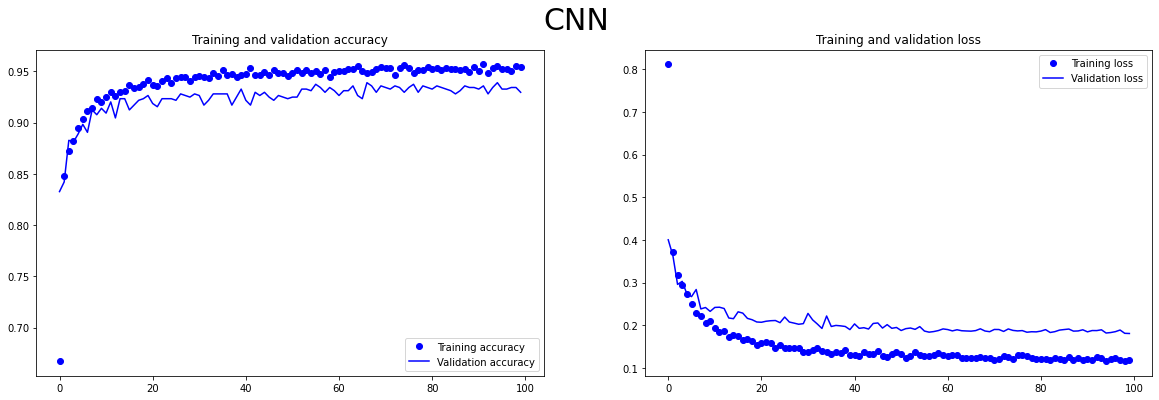

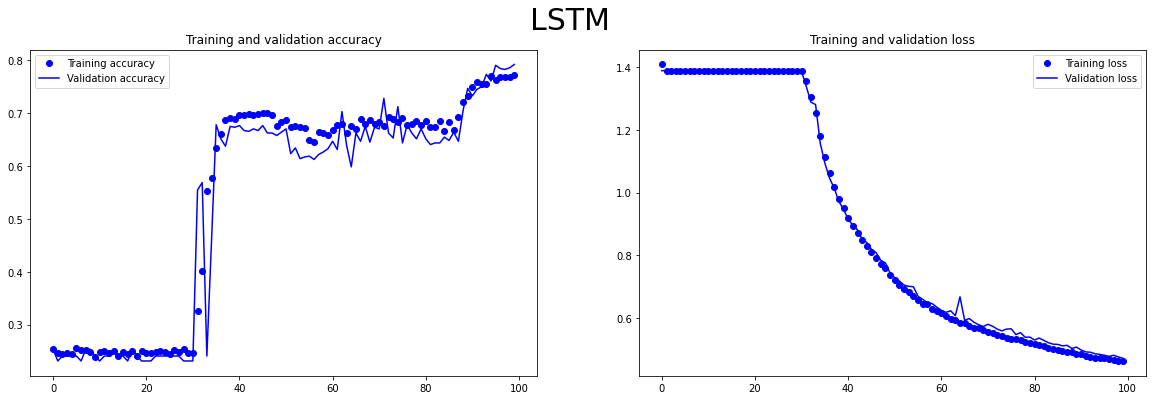

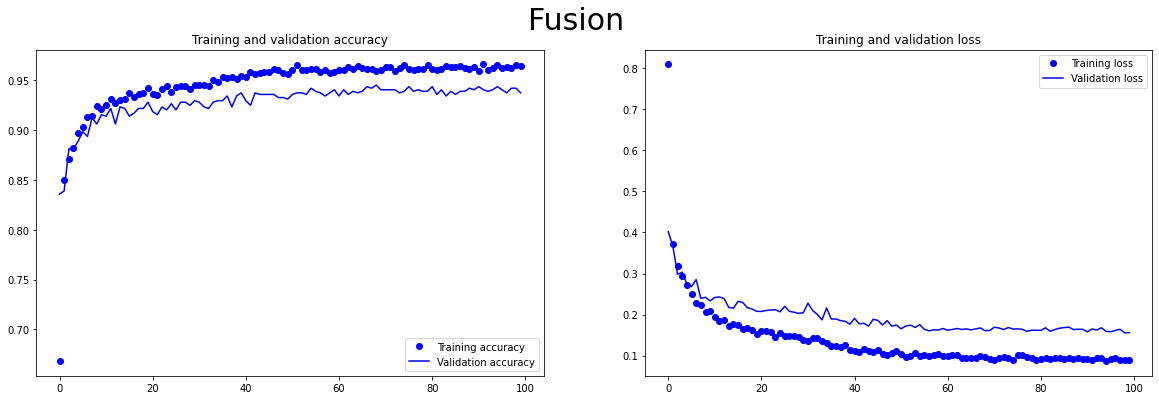

In [25]:
fusion_evaluation(history_104)

     Actual  Predicted_CNN  Predicted_lstm  Predicted_fusion
0         1              1               1                 1
1         1              1               2                 1
2         2              2               2                 2
3         0              0               0                 0
4         1              2               2                 2
5         1              2               1                 2
6         3              3               3                 3
7         2              1               1                 1
8         2              2               2                 2
9         3              3               3                 3
10        3              3               3                 3
11        0              0               0                 0
12        1              1               1                 1
13        0              0               0                 0
14        2              2               1                 2
15        2             

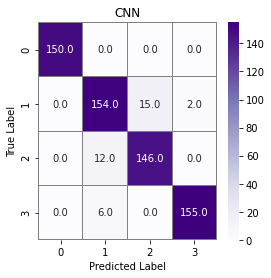

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       150
     Class 1       0.90      0.90      0.90       171
     Class 2       0.91      0.92      0.92       158
     Class 3       0.99      0.96      0.97       161

    accuracy                           0.95       640
   macro avg       0.95      0.95      0.95       640
weighted avg       0.95      0.95      0.95       640



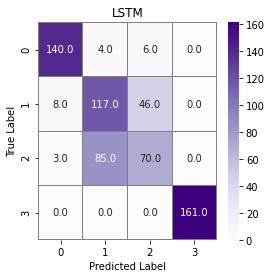

              precision    recall  f1-score   support

     Class 0       0.93      0.93      0.93       150
     Class 1       0.57      0.68      0.62       171
     Class 2       0.57      0.44      0.50       158
     Class 3       1.00      1.00      1.00       161

    accuracy                           0.76       640
   macro avg       0.77      0.77      0.76       640
weighted avg       0.76      0.76      0.76       640



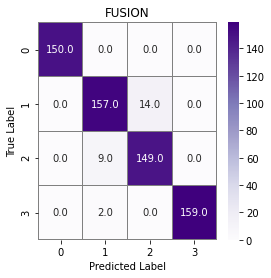

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       150
     Class 1       0.93      0.92      0.93       171
     Class 2       0.91      0.94      0.93       158
     Class 3       1.00      0.99      0.99       161

    accuracy                           0.96       640
   macro avg       0.96      0.96      0.96       640
weighted avg       0.96      0.96      0.96       640



In [26]:
test_model(model_104,testImagesX,testAttrX_new,testY_new)

In [27]:
model_104.save("model_4classes_seek100.h5")

In [28]:
model_104.save_weights("model_4classes_seek_weights100.h5")

In [29]:
from keras.models import load_model

In [30]:
model_test = load_model('/content/model_4classes_seek100.h5')
result=model_test.predict([testImagesX,testAttrX_new])

In [73]:
result[0][0:250]

array([[5.77402339e-08, 6.42237186e-01, 3.57762694e-01, 3.59397858e-15],
       [8.84138179e-11, 9.87684071e-01, 1.16506983e-02, 6.65209838e-04],
       [2.45508169e-10, 1.21738733e-04, 9.99878287e-01, 1.58260110e-13],
       [1.00000000e+00, 5.60042410e-13, 2.04921453e-12, 1.07701211e-18],
       [4.35562836e-10, 3.92606929e-02, 9.60739315e-01, 3.23208712e-12],
       [1.18954194e-05, 5.45332767e-02, 9.45454776e-01, 1.50127519e-08],
       [7.54563313e-16, 9.35191230e-04, 1.05633932e-04, 9.98959184e-01],
       [1.44497109e-10, 9.05155480e-01, 9.48443711e-02, 1.12363054e-07],
       [9.13932681e-08, 4.46444436e-04, 9.99553382e-01, 1.27733472e-07],
       [1.25987531e-13, 5.52586839e-03, 7.17039627e-04, 9.93757129e-01],
       [5.27043587e-23, 6.37640219e-15, 3.87540694e-11, 1.00000000e+00],
       [1.00000000e+00, 4.09920849e-14, 2.89732571e-10, 1.90387541e-13],
       [2.13436582e-12, 8.85497093e-01, 3.66745256e-02, 7.78283849e-02],
       [1.00000000e+00, 1.12961066e-13, 5.10182478e

In [74]:
result[0][250:500]

array([[3.67834062e-12, 8.19764853e-01, 2.53776629e-02, 1.54857457e-01],
       [1.36328657e-10, 4.17775512e-01, 3.94408882e-01, 1.87815621e-01],
       [1.19536054e-12, 3.04906652e-03, 4.88194608e-04, 9.96462762e-01],
       [2.18064583e-14, 1.34322862e-03, 4.23910184e-04, 9.98232841e-01],
       [1.80804080e-10, 5.16215841e-05, 4.08026564e-04, 9.99540329e-01],
       [1.00000000e+00, 7.80801113e-09, 1.36588385e-08, 8.08243143e-12],
       [4.46178820e-13, 2.64595915e-03, 2.11449340e-03, 9.95239496e-01],
       [3.94180414e-16, 9.98928368e-01, 1.07165531e-03, 1.38145023e-10],
       [3.66059683e-11, 9.75175858e-01, 2.48241555e-02, 9.75631360e-13],
       [9.64406913e-14, 3.54217900e-06, 7.59238355e-06, 9.99988914e-01],
       [9.99999881e-01, 1.85750682e-09, 1.10941244e-07, 1.02506309e-10],
       [8.76469036e-13, 9.99295950e-01, 7.03869620e-04, 7.89275987e-08],
       [1.33491506e-16, 9.98722970e-01, 1.27702253e-03, 8.04504293e-12],
       [2.56113197e-16, 3.05018624e-08, 3.33462231e

In [76]:
result[0][500:641]

array([[1.00000000e+00, 1.48582986e-11, 1.11193818e-10, 9.87666555e-18],
       [1.00000000e+00, 2.22250861e-13, 1.04078413e-11, 8.77979325e-19],
       [1.00000000e+00, 4.50864623e-11, 2.46792142e-10, 8.95047247e-14],
       [1.37281442e-09, 2.04620697e-02, 9.79530692e-01, 7.25163136e-06],
       [1.00000000e+00, 2.07539653e-15, 7.68535626e-14, 1.04197262e-21],
       [3.43142887e-07, 3.46743912e-02, 9.65325236e-01, 2.16726388e-08],
       [6.63874672e-16, 1.24747909e-04, 1.03702650e-05, 9.99864817e-01],
       [3.45866402e-13, 7.58673809e-03, 9.92413223e-01, 1.22464172e-08],
       [9.99999523e-01, 5.15184020e-08, 4.30074266e-07, 6.10372169e-11],
       [2.36620814e-15, 6.88642540e-05, 1.06653022e-06, 9.99930024e-01],
       [3.90470669e-15, 1.24025042e-03, 6.35568358e-05, 9.98696268e-01],
       [1.00000000e+00, 1.54222880e-13, 7.65531388e-12, 6.40801246e-20],
       [1.23076784e-14, 4.24384931e-03, 9.95725155e-01, 3.10383693e-05],
       [3.05174155e-15, 1.14560581e-03, 1.22702768e

In [78]:
result[1][0:250]

array([[0.02465324, 0.4901247 , 0.46717748, 0.01804464],
       [0.02328381, 0.47149506, 0.5020171 , 0.00320396],
       [0.02343476, 0.48248333, 0.48797956, 0.00610232],
       [0.95617145, 0.00942807, 0.0122431 , 0.02215734],
       [0.0277129 , 0.47899956, 0.48329085, 0.00999665],
       [0.02487691, 0.4906591 , 0.44909295, 0.03537104],
       [0.01583022, 0.01975377, 0.0178462 , 0.94656986],
       [0.03777425, 0.45624474, 0.41547966, 0.09050131],
       [0.21846493, 0.35249695, 0.40160176, 0.02743643],
       [0.02085716, 0.00469734, 0.00475225, 0.96969324],
       [0.01476016, 0.01490563, 0.01325764, 0.9570766 ],
       [0.9698836 , 0.00452617, 0.00633654, 0.01925367],
       [0.03347731, 0.46830055, 0.42414427, 0.07407784],
       [0.9775258 , 0.0017359 , 0.00279148, 0.01794681],
       [0.02375142, 0.4897491 , 0.47418076, 0.01231874],
       [0.0369065 , 0.47229558, 0.45304662, 0.03775125],
       [0.03222715, 0.4763977 , 0.44290116, 0.04847401],
       [0.02356839, 0.04939977,

In [79]:
result[1][250:500]

array([[0.02626547, 0.48579288, 0.437609  , 0.05033265],
       [0.02336984, 0.47728693, 0.49505407, 0.00428921],
       [0.01643481, 0.13571332, 0.10921344, 0.7386384 ],
       [0.01593052, 0.0635907 , 0.05285146, 0.8676273 ],
       [0.01729645, 0.00673964, 0.00638324, 0.96958065],
       [0.9792346 , 0.00154889, 0.00247266, 0.01674389],
       [0.01826178, 0.08298837, 0.0707875 , 0.82796234],
       [0.02602322, 0.47954902, 0.4866597 , 0.00776798],
       [0.02618991, 0.48822695, 0.44685572, 0.03872747],
       [0.01754321, 0.00792575, 0.00748168, 0.96704936],
       [0.97627366, 0.00253897, 0.00380983, 0.01737751],
       [0.02642597, 0.4684412 , 0.50103205, 0.00410076],
       [0.02732087, 0.4772964 , 0.48722294, 0.00815989],
       [0.01576997, 0.01933096, 0.01731129, 0.9475878 ],
       [0.9805581 , 0.00131999, 0.00208715, 0.0160348 ],
       [0.0246616 , 0.47507918, 0.49560863, 0.00465065],
       [0.02081627, 0.00765594, 0.00770991, 0.96381783],
       [0.01499437, 0.01808372,

In [80]:
result[1][500:640]

array([[0.9693412 , 0.004335  , 0.00609351, 0.02023025],
       [0.97026056, 0.00453894, 0.00630088, 0.01889964],
       [0.9803617 , 0.00134473, 0.00213147, 0.01616214],
       [0.02493004, 0.4907306 , 0.46143854, 0.02290082],
       [0.97837   , 0.00177816, 0.00278586, 0.01706597],
       [0.02425255, 0.4927913 , 0.45548517, 0.02747104],
       [0.01834475, 0.00479465, 0.00467912, 0.9721815 ],
       [0.03007998, 0.47385988, 0.42475602, 0.07130409],
       [0.97220606, 0.00306659, 0.00457769, 0.02014973],
       [0.01665909, 0.00765877, 0.00723326, 0.9684488 ],
       [0.01551905, 0.02797505, 0.02446133, 0.93204457],
       [0.9773777 , 0.00175211, 0.00281754, 0.01805272],
       [0.02504754, 0.48853528, 0.43935755, 0.0470596 ],
       [0.01615502, 0.07153672, 0.05946331, 0.8528449 ],
       [0.03033392, 0.4736599 , 0.42397135, 0.07203481],
       [0.98143584, 0.00129064, 0.00204015, 0.0152334 ],
       [0.01847136, 0.02977938, 0.02724603, 0.92450327],
       [0.01434642, 0.02826797,

In [68]:
result[2][0:250]

array([[4.96914154e-08, 6.22047722e-01, 3.77952218e-01, 1.78903629e-15],
       [2.82354608e-11, 9.91087735e-01, 8.88781156e-03, 2.44610565e-05],
       [9.42942044e-11, 1.51616536e-04, 9.99848366e-01, 7.08045005e-15],
       [1.00000000e+00, 1.58183403e-13, 1.87932113e-12, 1.04789813e-17],
       [7.24894103e-11, 3.97397429e-02, 9.60260272e-01, 1.39114374e-13],
       [2.29393954e-05, 7.32790306e-02, 9.26698089e-01, 2.68387375e-08],
       [2.36159747e-16, 1.34074842e-04, 1.65511792e-05, 9.99849319e-01],
       [3.65640539e-11, 9.02708292e-01, 9.72917303e-02, 1.34314426e-08],
       [4.76069992e-08, 4.58931725e-04, 9.99541044e-01, 1.27233850e-08],
       [2.89197851e-14, 2.98723695e-04, 5.11166618e-05, 9.99650121e-01],
       [2.80621856e-22, 4.75451181e-14, 2.33807917e-10, 1.00000000e+00],
       [1.00000000e+00, 6.48527134e-15, 1.25244357e-10, 1.35585152e-12],
       [2.13921220e-12, 9.39489186e-01, 4.07104082e-02, 1.98004376e-02],
       [1.00000000e+00, 2.38459799e-14, 4.75380933e

In [69]:
result[2][250:500]

array([[2.97473699e-12, 9.48788822e-01, 2.95139756e-02, 2.16972884e-02],
       [7.23748977e-11, 4.34698969e-01, 5.55552661e-01, 9.74834710e-03],
       [1.13449452e-12, 1.97931239e-03, 2.58080196e-04, 9.97762561e-01],
       [1.31125723e-14, 4.81760158e-04, 1.38669537e-04, 9.99379516e-01],
       [3.34648524e-11, 2.32893490e-06, 2.44602834e-05, 9.99973178e-01],
       [1.00000000e+00, 7.31350036e-10, 5.13107024e-09, 3.63227282e-10],
       [4.69901624e-13, 1.27037463e-03, 9.24186839e-04, 9.97805417e-01],
       [2.52611218e-16, 9.99024272e-01, 9.75761737e-04, 2.07491455e-11],
       [3.82130057e-11, 9.76899445e-01, 2.31005494e-02, 7.30552229e-13],
       [5.21096499e-14, 4.05184409e-07, 1.51192307e-06, 9.99998093e-01],
       [1.00000000e+00, 2.87350671e-10, 5.55002337e-08, 9.22454002e-10],
       [5.17874860e-13, 9.99169350e-01, 8.30714067e-04, 6.53566046e-09],
       [9.61709363e-17, 9.98716116e-01, 1.28392596e-03, 2.05255669e-12],
       [2.15131823e-16, 1.81869275e-08, 2.44376570e

In [70]:
result[2][500:640]

array([[1.00000000e+00, 2.65649243e-12, 7.35493194e-11, 2.52250038e-16],
       [1.00000000e+00, 7.58836218e-14, 1.21959049e-11, 9.42013878e-18],
       [1.00000000e+00, 3.49294595e-12, 6.26893051e-11, 2.22931114e-12],
       [6.64726274e-10, 2.77671590e-02, 9.72232103e-01, 7.89331295e-07],
       [1.00000000e+00, 5.29984968e-16, 8.44378820e-14, 2.84310442e-20],
       [1.81975025e-07, 4.21622656e-02, 9.57837522e-01, 1.15065224e-09],
       [2.78992033e-16, 1.27309841e-05, 1.44181649e-06, 9.99985814e-01],
       [2.66115472e-13, 9.96059738e-03, 9.90039408e-01, 1.11592369e-09],
       [9.99999642e-01, 1.20855548e-08, 3.59110999e-07, 6.79131140e-10],
       [1.80395614e-15, 1.39725717e-05, 3.55557177e-07, 9.99985695e-01],
       [1.79122523e-15, 2.23701631e-04, 1.02319700e-05, 9.99766052e-01],
       [1.00000000e+00, 3.47807720e-14, 7.76082844e-12, 1.83129061e-18],
       [1.33194330e-14, 6.12115022e-03, 9.93867815e-01, 1.09923185e-05],
       [1.62126797e-15, 6.44553511e-04, 5.26230069e

In [34]:
model_test.evaluate([testImagesX,testAttrX_new],testY)

20/20 [==============================] - 5s 207ms/step - loss: 0.8569 - CNN_output_loss: 0.1667 - LSTM_output_loss: 0.4810 - FUSION_output_loss: 0.1342 - CNN_output_CNN_output_accuracy: 0.9453 - LSTM_output_LSTM_output_accuracy: 0.7625 - FUSION_output_FUSION_output_accuracy: 0.9609


[0.8568961024284363,
 0.16665886342525482,
 0.4810473918914795,
 0.1342068761587143,
 0.9453125,
 0.762499988079071,
 0.9609375]

In [43]:
pred_cnn = np.argmax(result[0], axis=-1)
pred_lstm = np.argmax(result[1], axis=-1)
pred_fusion = np.argmax(result[2], axis=-1)

In [44]:
pred_cnn

array([1, 1, 2, 0, 2, 2, 3, 1, 2, 3, 3, 0, 1, 0, 2, 2, 1, 3, 2, 0, 0, 0,
       0, 3, 0, 2, 2, 2, 1, 3, 2, 1, 1, 0, 1, 2, 2, 2, 3, 2, 1, 3, 2, 2,
       0, 1, 1, 2, 3, 2, 0, 2, 3, 1, 1, 3, 2, 0, 0, 2, 0, 0, 3, 3, 3, 0,
       3, 2, 1, 3, 1, 0, 1, 1, 0, 2, 2, 1, 1, 1, 2, 1, 2, 0, 2, 3, 1, 3,
       1, 0, 1, 1, 3, 2, 1, 1, 0, 3, 1, 1, 1, 0, 0, 3, 0, 1, 2, 3, 3, 0,
       1, 1, 1, 3, 0, 1, 3, 0, 3, 1, 3, 1, 0, 3, 0, 1, 0, 3, 3, 1, 2, 1,
       2, 0, 2, 2, 0, 3, 3, 2, 1, 0, 0, 0, 2, 2, 3, 3, 0, 1, 1, 1, 2, 0,
       2, 2, 3, 1, 1, 2, 0, 2, 3, 2, 1, 3, 2, 3, 0, 0, 1, 1, 3, 2, 2, 3,
       2, 0, 0, 1, 0, 0, 0, 1, 2, 3, 2, 1, 2, 1, 0, 0, 0, 2, 3, 1, 1, 0,
       3, 0, 2, 1, 2, 3, 0, 0, 3, 3, 3, 2, 1, 1, 0, 2, 0, 0, 1, 2, 1, 3,
       1, 2, 2, 1, 1, 2, 2, 1, 1, 3, 1, 0, 1, 1, 2, 3, 3, 3, 3, 0, 3, 0,
       0, 0, 0, 3, 0, 3, 1, 3, 1, 1, 3, 3, 3, 0, 3, 1, 1, 3, 0, 1, 1, 3,
       0, 2, 3, 3, 3, 0, 0, 0, 3, 0, 2, 1, 0, 1, 0, 3, 1, 1, 0, 1, 1, 2,
       0, 1, 2, 2, 3, 3, 0, 2, 2, 2, 0, 0, 2, 0, 3,

In [45]:
pred_lstm

array([1, 2, 2, 0, 2, 1, 3, 1, 2, 3, 3, 0, 1, 0, 1, 1, 1, 3, 2, 1, 0, 0,
       0, 3, 0, 2, 2, 1, 1, 3, 1, 2, 2, 0, 0, 2, 1, 1, 3, 1, 1, 3, 1, 1,
       2, 2, 1, 1, 3, 2, 1, 2, 3, 1, 2, 3, 2, 0, 0, 1, 0, 1, 3, 3, 3, 0,
       3, 2, 1, 3, 1, 0, 1, 3, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 3, 2, 3,
       1, 0, 1, 2, 3, 2, 1, 1, 0, 3, 1, 1, 1, 1, 0, 3, 0, 2, 1, 3, 3, 0,
       1, 2, 1, 3, 0, 1, 3, 0, 3, 1, 3, 1, 0, 3, 0, 1, 0, 3, 3, 2, 1, 1,
       1, 0, 2, 2, 0, 3, 1, 1, 2, 0, 0, 0, 1, 1, 3, 3, 0, 1, 2, 1, 2, 0,
       1, 1, 3, 2, 3, 1, 0, 1, 3, 1, 2, 3, 2, 3, 0, 0, 1, 1, 3, 2, 2, 3,
       2, 0, 0, 1, 0, 0, 0, 1, 1, 3, 1, 2, 1, 1, 0, 0, 0, 1, 3, 1, 1, 0,
       3, 0, 2, 3, 2, 3, 0, 0, 3, 3, 3, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 3,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 3, 1, 0, 2, 2, 1, 3, 3, 3, 3, 0, 3, 0,
       0, 0, 0, 3, 0, 3, 1, 3, 1, 2, 3, 3, 3, 0, 3, 2, 1, 3, 0, 2, 2, 3,
       0, 2, 3, 3, 3, 0, 2, 0, 3, 0, 1, 1, 0, 1, 0, 3, 3, 1, 0, 1, 1, 1,
       0, 0, 2, 1, 3, 3, 0, 1, 1, 1, 0, 0, 2, 0, 3,

In [46]:
pred_fusion

array([1, 1, 2, 0, 2, 2, 3, 1, 2, 3, 3, 0, 1, 0, 2, 2, 1, 3, 2, 0, 0, 0,
       0, 3, 0, 2, 2, 2, 1, 3, 2, 1, 1, 0, 1, 2, 2, 2, 3, 2, 1, 3, 2, 2,
       0, 1, 1, 2, 3, 2, 0, 2, 3, 1, 1, 3, 2, 0, 0, 2, 0, 0, 3, 3, 3, 0,
       3, 2, 1, 3, 1, 0, 1, 3, 0, 2, 2, 1, 1, 1, 2, 1, 2, 0, 2, 3, 1, 3,
       1, 0, 1, 1, 3, 2, 1, 1, 0, 3, 1, 1, 1, 0, 0, 3, 0, 1, 1, 3, 3, 0,
       1, 1, 1, 3, 0, 1, 3, 0, 3, 1, 3, 1, 0, 3, 0, 1, 0, 3, 3, 1, 2, 1,
       2, 0, 2, 2, 0, 3, 1, 2, 1, 0, 0, 0, 2, 2, 3, 3, 0, 1, 1, 1, 2, 0,
       2, 2, 3, 1, 1, 2, 0, 2, 3, 2, 1, 3, 2, 3, 0, 0, 1, 1, 3, 2, 2, 3,
       2, 0, 0, 1, 0, 0, 0, 1, 2, 3, 2, 1, 2, 1, 0, 0, 0, 2, 3, 1, 1, 0,
       3, 0, 2, 3, 2, 3, 0, 0, 3, 3, 3, 2, 1, 1, 0, 2, 0, 0, 1, 2, 1, 3,
       1, 2, 2, 2, 1, 2, 2, 1, 1, 3, 1, 0, 1, 1, 2, 3, 3, 3, 3, 0, 3, 0,
       0, 0, 0, 3, 0, 3, 1, 3, 1, 2, 3, 3, 3, 0, 3, 1, 1, 3, 0, 1, 1, 3,
       0, 2, 3, 3, 3, 0, 0, 0, 3, 0, 2, 1, 0, 1, 0, 3, 3, 1, 0, 1, 1, 2,
       0, 1, 2, 2, 3, 3, 0, 2, 2, 2, 0, 0, 2, 0, 3,

In [47]:
testY

image1900031           1
image900106            1
image2100103           2
mix2300817             0
image600415            1
image100218            1
image2906261           3
image500183            2
image300133            2
image2907161           3
image2500838           3
mix900241              0
image2807661           1
mix2200421             0
image1700713           2
image2100220 - Copy    2
image2804661           1
image2915821           3
image2808441           2
mix2300223             0
mix300331              0
mix1300661             0
mix1500991             0
image2600469           3
mix1200106             0
image100105            2
image400233            2
image1700539           2
image600505            1
image2909761           3
image2000126 - Copy    2
image900022            1
image2807081 - Copy    2
mix2400349             0
image1000190           1
image2703321           2
image2200097           2
image600135            2
image2500163           3
image1600127           2
